In [67]:
import os
import wget
import zipfile
import re
import logging
import argparse
import random
import time
import copy
import numpy as np
from functools import partial
import torch
import torchtext.data as data
import torchtext.vocab as vocab
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertModel
from utils import lr_finder, learner, validate, MyIterator
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from importlib import reload

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [84]:
def replace_unknown(x, word_list):
    if x in word_list:
        return x
    else:
        return '[UNK]'


def get_dataset():
    logging.info('Downloading data')
    if not os.path.exists('data'):
        os.makedirs('data')
    if not os.listdir('data'):
        wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment labelled sentences.zip', out='data/data.zip')
        with zipfile.ZipFile('data/data.zip', 'r') as myzip:
            myzip.extractall('data/')

    # separate lines into reviews and class labels
    path = os.path.abspath('data/sentiment labelled sentences')
    regex = re.compile(r'^(.*?)\s+(\d)$')
    reviews = []
    for file in ['imdb_labelled.txt', 'amazon_cells_labelled.txt', 'yelp_labelled.txt']:
        with open(os.path.join(path, file)) as f:
            for line in f:
                result = regex.match(line)
                reviews.append([result.group(1), int(result.group(2))])

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    TEXT = data.Field(tokenize=tokenizer.tokenize, lower=True, batch_first=True)
    LABEL = data.Field(sequential=False, use_vocab=False)
    fields = [('review', TEXT), ('label', LABEL)]

    logging.info('Downloading BERT word vectors')

    # pipeline for replacing words that do not appear in GloVe vocab
    pipe = data.Pipeline(partial(replace_unknown, word_list=list(tokenizer.vocab.keys())))
    TEXT.preprocessing = pipe

    examples = [data.Example.fromlist(review, fields) for review in reviews]
    dataset = data.Dataset(examples, fields)

    model = BertModel.from_pretrained('bert-base-uncased')
    emb_vecs = model.get_input_embeddings().weight
    dim = emb_vecs.shape[1]

    TEXT.build_vocab(dataset)
    vectors = [torch.normal(mean=torch.ones(1, dim), std=torch.ones(1, dim)),
               torch.zeros(1, dim)]
    
    for word in TEXT.vocab.itos[2:]:
        word_id = tokenizer.vocab[word]
        vectors.append(emb_vecs[word_id].unsqueeze(0))
    TEXT.vocab.vectors = torch.cat(vectors, dim=0)

    return dataset, TEXT.vocab.vectors

In [85]:
dataset, emb_weights =  get_dataset()

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

05/13/2020 10:45:01 AM INFO : Downloading data
05/13/2020 10:45:02 AM INFO : loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
05/13/2020 10:45:02 AM INFO : Downloading BERT word vectors
05/13/2020 10:45:08 AM INFO : loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
05/13/2020 10:45:08 AM INFO : Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  

In [88]:
class CNN(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()

        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(1, out_channels, (kernel_heights[1], self.embedding_length), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(1, out_channels, (kernel_heights[2], self.embedding_length), stride, (padding[2], 0))
        # self.conv4 = nn.Conv2d(1, out_channels, (kernel_heights[3], self.embedding_length), stride, (padding[3], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(len(kernel_heights)*out_channels, 2)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input)# conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = self.relu(conv_out.squeeze(3))# activation.size() = (batch_size, out_channels, dim1)
        max_out = nn.functional.max_pool1d(activation, activation.size()[2]).squeeze(2)# maxpool_out.size() = (batch_size, out_channels)

        return max_out

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)

        max_out = []
        max_out.append(self.conv_block(self.dropout0(input), self.conv1))
        max_out.append(self.conv_block(self.dropout0(input), self.conv2))
        max_out.append(self.conv_block(self.dropout0(input), self.conv3))

        all_out = torch.cat(max_out, dim=1)

        return self.head(self.dropout1(all_out))

In [96]:
model = CNN(out_channels=16, kernel_heights=(1, 3, 5), stride=1, padding=(0, 1, 2), dropout=(0.3, 0.3), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)

Finding learning rate ...100%

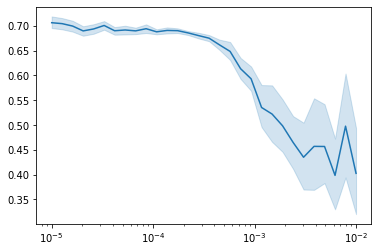

In [90]:
optimiser = Adam(model.parameters())
lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [97]:
optimiser = Adam(model.parameters())
scheduler_fn = partial(OneCycleLR, pct_start=0.3, max_lr=5e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=10, bs=8, scheduler_fn=scheduler_fn)

05/13/2020 10:50:42 AM INFO : Epoch : 1, batch : 100, train_loss = 0.6936, val_loss = 0.6848, val_accuracy : 0.680, time = 1s
05/13/2020 10:50:43 AM INFO : Epoch : 1, batch : 200, train_loss = 0.6728, val_loss = 0.6617, val_accuracy : 0.573, time = 2s
05/13/2020 10:50:44 AM INFO : Epoch : 1, batch : 300, train_loss = 0.6466, val_loss = 0.6483, val_accuracy : 0.740, time = 3s
05/13/2020 10:50:45 AM INFO : Epoch : 2, batch : 100, train_loss = 0.6314, val_loss = 0.6165, val_accuracy : 0.750, time = 4s
05/13/2020 10:50:46 AM INFO : Epoch : 2, batch : 200, train_loss = 0.5718, val_loss = 0.5658, val_accuracy : 0.810, time = 5s
05/13/2020 10:50:47 AM INFO : Epoch : 2, batch : 300, train_loss = 0.5461, val_loss = 0.5537, val_accuracy : 0.803, time = 6s
05/13/2020 10:50:48 AM INFO : Epoch : 3, batch : 100, train_loss = 0.5272, val_loss = 0.5246, val_accuracy : 0.807, time = 7s
05/13/2020 10:50:49 AM INFO : Epoch : 3, batch : 200, train_loss = 0.4643, val_loss = 0.4830, val_accuracy : 0.843, ti

In [98]:
scheduler_fn = partial(OneCycleLR, pct_start=0.3, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8, scheduler_fn=scheduler_fn)

05/13/2020 10:51:46 AM INFO : Epoch : 1, batch : 100, train_loss = 0.2318, val_loss = 0.3041, val_accuracy : 0.880, time = 1s
05/13/2020 10:51:47 AM INFO : Epoch : 1, batch : 200, train_loss = 0.1688, val_loss = 0.3053, val_accuracy : 0.880, time = 2s
05/13/2020 10:51:48 AM INFO : Epoch : 1, batch : 300, train_loss = 0.3055, val_loss = 0.3058, val_accuracy : 0.880, time = 3s
05/13/2020 10:51:49 AM INFO : Epoch : 2, batch : 100, train_loss = 0.2284, val_loss = 0.3024, val_accuracy : 0.883, time = 4s
05/13/2020 10:51:50 AM INFO : Epoch : 2, batch : 200, train_loss = 0.1661, val_loss = 0.3042, val_accuracy : 0.880, time = 5s
05/13/2020 10:51:51 AM INFO : Epoch : 2, batch : 300, train_loss = 0.3029, val_loss = 0.3050, val_accuracy : 0.880, time = 6s
05/13/2020 10:51:52 AM INFO : Epoch : 3, batch : 100, train_loss = 0.2187, val_loss = 0.3010, val_accuracy : 0.887, time = 6s
05/13/2020 10:51:53 AM INFO : Epoch : 3, batch : 200, train_loss = 0.1599, val_loss = 0.3036, val_accuracy : 0.880, ti

In [99]:
model.word_embeddings.weight.requires_grad_(True);
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8, scheduler_fn=scheduler_fn)

05/13/2020 10:52:27 AM INFO : Epoch : 1, batch : 100, train_loss = 0.2137, val_loss = 0.2973, val_accuracy : 0.887, time = 4s
05/13/2020 10:52:32 AM INFO : Epoch : 1, batch : 200, train_loss = 0.1399, val_loss = 0.2968, val_accuracy : 0.890, time = 9s
05/13/2020 10:52:36 AM INFO : Epoch : 1, batch : 300, train_loss = 0.2804, val_loss = 0.2962, val_accuracy : 0.887, time = 13s
05/13/2020 10:52:41 AM INFO : Epoch : 2, batch : 100, train_loss = 0.1741, val_loss = 0.2909, val_accuracy : 0.883, time = 17s
05/13/2020 10:52:45 AM INFO : Epoch : 2, batch : 200, train_loss = 0.1365, val_loss = 0.2891, val_accuracy : 0.887, time = 22s
05/13/2020 10:52:49 AM INFO : Epoch : 2, batch : 300, train_loss = 0.2674, val_loss = 0.2884, val_accuracy : 0.900, time = 26s
05/13/2020 10:52:53 AM INFO : Epoch : 3, batch : 100, train_loss = 0.1382, val_loss = 0.2839, val_accuracy : 0.883, time = 30s
05/13/2020 10:52:57 AM INFO : Epoch : 3, batch : 200, train_loss = 0.0987, val_loss = 0.2854, val_accuracy : 0.89

In [100]:
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=5e-5, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8, scheduler_fn=scheduler_fn)

05/13/2020 10:57:35 AM INFO : Epoch : 1, batch : 100, train_loss = 0.0748, val_loss = 0.2790, val_accuracy : 0.897, time = 4s
05/13/2020 10:57:39 AM INFO : Epoch : 1, batch : 200, train_loss = 0.0620, val_loss = 0.2800, val_accuracy : 0.897, time = 8s
05/13/2020 10:57:43 AM INFO : Epoch : 1, batch : 300, train_loss = 0.2134, val_loss = 0.2803, val_accuracy : 0.897, time = 12s
05/13/2020 10:57:47 AM INFO : Epoch : 2, batch : 100, train_loss = 0.0689, val_loss = 0.2786, val_accuracy : 0.900, time = 16s
05/13/2020 10:57:52 AM INFO : Epoch : 2, batch : 200, train_loss = 0.0589, val_loss = 0.2799, val_accuracy : 0.893, time = 20s
05/13/2020 10:57:56 AM INFO : Epoch : 2, batch : 300, train_loss = 0.2126, val_loss = 0.2799, val_accuracy : 0.893, time = 25s
05/13/2020 10:58:00 AM INFO : Epoch : 3, batch : 100, train_loss = 0.0628, val_loss = 0.2794, val_accuracy : 0.897, time = 29s
05/13/2020 10:58:04 AM INFO : Epoch : 3, batch : 200, train_loss = 0.0524, val_loss = 0.2806, val_accuracy : 0.89